In [1]:
import os
import json
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Config
MODEL = "google/gemini-3-pro-preview"
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

if not OPENROUTER_API_KEY:
    raise ValueError("Set OPENROUTER_API_KEY environment variable")


In [2]:
# Load data
df = pd.read_csv("cleaned_resumes.csv")

# Get 20% stratified test set
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["experience_level"])
test_df = test_df.reset_index(drop=True)

print(f"Test set: {len(test_df)} samples")
print(test_df["experience_level"].value_counts())


Test set: 420 samples
experience_level
mid       140
junior    140
senior    140
Name: count, dtype: int64


In [3]:
# Columns to include in the prompt (exclude target and personal info)
EXCLUDE_COLS = {"experience_level"}

def build_resume_text(row):
    """Build resume text from row data."""
    parts = []
    for col in row.index:
        if col not in EXCLUDE_COLS:
            val = str(row[col]).strip()
            if val and val.lower() != "nan":
                parts.append(f"{col}: {val}")
    return "\n".join(parts)

def call_api(resume_text):
    """Call API and return the predicted label (junior/mid/senior)."""
    prompt = f"""Respond with what you think the person's seniority level is based on the following data a dataset (Respond with one word out of these three only only: mid, junior, or senior. DO NOT put too much weight on the experience time. your answer should be mostly based on their past experiences and the summary mostly.):\n
    {resume_text}
"""
    
    payload = json.dumps({
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        # "max_tokens": 16
    }).encode("utf-8")
    
    req = urllib.request.Request(
        OPENROUTER_URL,
        data=payload,
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        }
    )
    
    try:
        with urllib.request.urlopen(req, timeout=120) as resp:
            result = json.loads(resp.read().decode("utf-8"))
    except urllib.error.HTTPError as e:
        error_body = e.read().decode("utf-8")
        raise Exception(f"HTTP {e.code}: {error_body}")
    
    response = result["choices"][0]["message"]["content"].strip().lower()
    
    # Extract valid label
    if "junior" in response.lower():
        return "junior"
    elif "mid" in response.lower():
        return "mid"
    elif "senior" in response.lower():
        return "senior"
    else:
        return "unknown"


In [ ]:
# Run classification (10 concurrent requests)
from concurrent.futures import ThreadPoolExecutor, as_completed

MAX_WORKERS = 10

n = len(test_df)
y_true = [None] * n
y_pred = [None] * n

# Pre-build texts (fast) and keep row order by using idx
tasks = []
for idx, row in test_df.iterrows():
    y_true[idx] = str(row["experience_level"]).strip().lower()
    tasks.append((idx, build_resume_text(row)))

def run_one(idx, resume_text):
    pred_label = call_api(resume_text)
    return idx, pred_label

processed = 0
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    future_to_idx = {executor.submit(run_one, idx, text): idx for idx, text in tasks}

    for future in as_completed(future_to_idx):
        idx = future_to_idx[future]
        try:
            _, pred_label = future.result()
        except Exception as e:
            print(f"Row {idx} failed: {e}")
            pred_label = "unknown"

        y_pred[idx] = pred_label
        processed += 1

        if processed % 50 == 0 or processed == n:
            print(f"Processed {processed}/{n}")

print(f"\nDone! {len(y_pred)} predictions")


Processed 50/420


Accuracy: 0.4333 (43.33%)

Classification Report:
              precision    recall  f1-score   support

      junior     1.0000    0.0143    0.0282       140
         mid     0.2993    0.3143    0.3066       140
      senior     0.5018    0.9714    0.6618       140

    accuracy                         0.4333       420
   macro avg     0.6004    0.4333    0.3322       420
weighted avg     0.6004    0.4333    0.3322       420



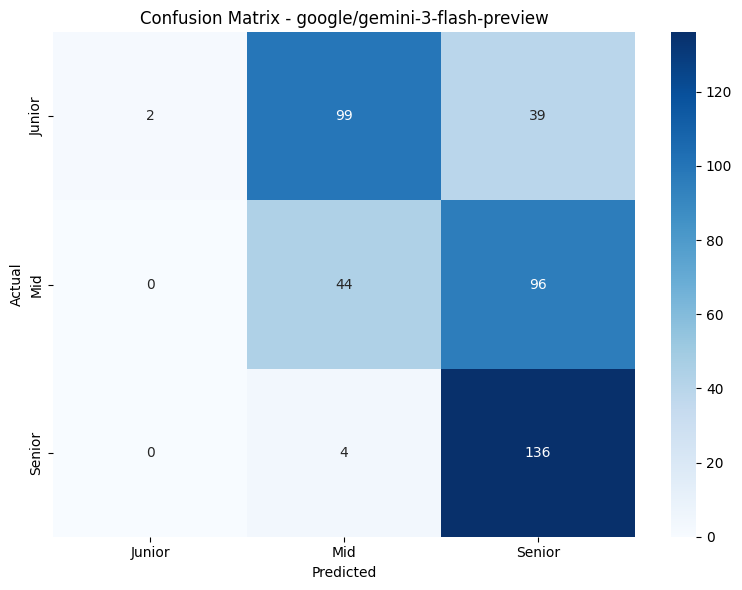

In [ ]:
# Results
labels = ["junior", "mid", "senior"]

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Junior', 'Mid', 'Senior'],
            yticklabels=['Junior', 'Mid', 'Senior'])
plt.title(f'Confusion Matrix - {MODEL}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()